In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [5]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
path_to_db='../../ESC-50/'
audio_dir = path_to_db + 'audio/'
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [7]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Loading

In [8]:
%%file load_blockwise.py

audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    h_target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_target.append(sample.h_target)
            target.append(sample.target)
        if debug:
            print("Done")
    if debug:
        print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_target), np.array(target)

def load_file_blockwise(filename, blocksize=1024, overlap=512, debug=False):
    items = []
    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + filename, 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True,
                         fill_value=0.0)
    sr = sf.info(audio_dir + filename).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = librosa.resample(y, sr, SR)
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        
    if debug:
        print("Done")

    return np.array(items)

Overwriting load_blockwise.py


In [9]:
%%time
from load_blockwise import load_audio_blockwise

%memit train_X, train_y, train_yy = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)

peak memory: 2454.06 MiB, increment: 2149.77 MiB
CPU times: user 4min 8s, sys: 1.78 s, total: 4min 10s
Wall time: 4min 10s


In [10]:
%%time
%memit test_X, test_y, test_yy = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

peak memory: 1809.90 MiB, increment: 511.45 MiB
CPU times: user 1min 1s, sys: 564 ms, total: 1min 1s
Wall time: 1min 2s


In [11]:
train_y = np.vstack([train_y, train_yy]).T
test_y = np.vstack([test_y, test_yy]).T

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [12]:
%%file cnnmult.py

import numpy as np
import inspect
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, InputLayer
from kapre.time_frequency import Melspectrogram, Spectrogram

from keras.wrappers.scikit_learn import KerasClassifier

SR=16000

class CNN_Multilayer(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=128, validation_split=0.05,
                       a_epochs=50, a_batch_size=128,
                       i_epochs=50, i_batch_size=128,
                       verbose=1):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)
            pass
    
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        
#         print(X.shape)
        
        dims = X.shape[1]
        t_y = y[:,0]
        a_y = y[:,1][t_y == 0]
        i_y = y[:,1][t_y == 1]
        
        """Top layer of hierarchy"""
        self.clf = KerasClassifier(build_fn=self.deep_net,
                                   feature_count=SR * 5,
                                   epochs=self.epochs, 
                                   batch_size=self.batch_size, 
                                   validation_split=self.validation_split,
                                   verbose=self.verbose
                                  )
        self.clf.fit(X, t_y)
        
        """Animal Layer"""
        self.a_clf = KerasClassifier(build_fn=self.deep_net_a,
                                       feature_count=SR * 5,
                                       epochs=self.a_epochs, 
                                       batch_size=self.a_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        
        self.a_clf.fit(X[t_y == 0], a_y)
        
        """Interacting Materials Layer"""
        self.i_clf = KerasClassifier(build_fn=self.deep_net_i, 
                                       feature_count=SR * 5,
                                       epochs=self.i_epochs, 
                                       batch_size=self.i_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        self.i_clf.fit(X[t_y == 1], i_y)
        
        return self
        
    def predict(self, X, y=None):
        predictions=[]
        
        for x in X:
            prob = self.clf.predict_proba(x, verbose=0).squeeze()
#             print(prob)
            if prob[0] > 0.75:
                pred = self.a_clf.predict(x, verbose=0).squeeze()
            elif prob[1] > 0.75:
                pred = self.i_clf.predict(x, verbose=0).squeeze()
            else:
                a_pred = self.a_clf.predict(x, verbose=0).squeeze()
                i_pred = self.i_clf.predict(x, verbose=0).squeeze()
                
                a_prob = self.a_clf.predict_proba(x, verbose=0).squeeze() * prob[0]
                i_prob = self.i_clf.predict_proba(x, verbose=0).squeeze() * prob[1]
                
                if(np.max(a_prob) > np.max(i_prob)):
                    pred = a_pred
                else:
                    pred = i_pred
                    
            predictions.append(pred)
        
        return predictions
    
    def predict_proba(self, X, y=None):
        
        prob = self.clf.predict_proba(X, verbose=0).squeeze()
#         print(prob)

        prob_a = np.multiply(self.a_clf.predict_proba(X, verbose=0).squeeze(),prob[0])
#         print(prob_a)

        prob_i = np.multiply(self.i_clf.predict_proba(X, verbose=0).squeeze(),prob[1])
#         print(prob_i)
#         print()
        
        probs = [None] * 50
        for counter, j in enumerate(self.a_clf.classes_):
            probs[j] = prob_a[counter]
        for counter, j in enumerate(self.i_clf.classes_):
            probs[j] = prob_i[counter]
            
        return np.array(probs)
        
    
    def deep_net(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        model.summary()


        return model

    def deep_net_a(self, feature_count):
        # Create Model
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(19, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    def deep_net_i(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(31, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

Overwriting cnnmult.py


In [13]:
from cnnmult import CNN_Multilayer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA

clf = CNN_Multilayer()

clf.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

1520/1520 [==============================] - 41s 27ms/step - loss: 0.1523 - acc: 0.9428 - val_loss: 0.9024 - val_acc: 0.7875
Epoch 48/50
1520/1520 [==============================] - 41s 27ms/step - loss: 0.1416 - acc: 0.9447 - val_loss: 0.7438 - val_acc: 0.8125
Epoch 49/50
1520/1520 [==============================] - 41s 27ms/step - loss: 0.1417 - acc: 0.9474 - val_loss: 0.8400 - val_acc: 0.8000
Epoch 50/50
1520/1520 [==============================] - 42s 28ms/step - loss: 0.2042 - acc: 0.9270 - val_loss: 0.7204 - val_acc: 0.8250
Train on 577 samples, validate on 31 samples
Epoch 1/50
577/577 [==============================] - 16s 28ms/step - loss: 2.9419 - acc: 0.0624 - val_loss: 2.9465 - val_acc: 0.0645
Epoch 2/50
577/577 [==============================] - 15s 27ms/step - loss: 2.9069 - acc: 0.0867 - val_loss: 2.9177 - val_acc: 0.0323
Epoch 3/50
577/577 [==============================] - 16s 28ms/step - loss: 2.8519 - acc: 0.0919 - val_loss: 2.8651 - val_acc: 0.0645
Epoch 4/50
577/57

942/942 [==============================] - 26s 28ms/step - loss: 2.8352 - acc: 0.1773 - val_loss: 2.9041 - val_acc: 0.1800
Epoch 15/50
942/942 [==============================] - 26s 28ms/step - loss: 2.7963 - acc: 0.1783 - val_loss: 2.8079 - val_acc: 0.1400
Epoch 16/50
942/942 [==============================] - 27s 29ms/step - loss: 2.7003 - acc: 0.2102 - val_loss: 2.6404 - val_acc: 0.1800
Epoch 17/50
942/942 [==============================] - 27s 28ms/step - loss: 2.6843 - acc: 0.2028 - val_loss: 2.5508 - val_acc: 0.2000
Epoch 18/50
942/942 [==============================] - 27s 28ms/step - loss: 2.6236 - acc: 0.2155 - val_loss: 2.5698 - val_acc: 0.1400
Epoch 19/50
942/942 [==============================] - 26s 27ms/step - loss: 2.5518 - acc: 0.2123 - val_loss: 2.5296 - val_acc: 0.2000
Epoch 20/50
942/942 [==============================] - 26s 28ms/step - loss: 2.5224 - acc: 0.2399 - val_loss: 2.3646 - val_acc: 0.2200
Epoch 21/50
942/942 [==============================] - 26s 28ms/ste

CNN_Multilayer(a_batch_size=128, a_epochs=50, batch_size=128, epochs=50,
        i_batch_size=128, i_epochs=50, validation_split=0.05, verbose=1)

In [14]:
print(test_X[:, np.newaxis, :, :].shape)

(400, 1, 1, 80000)


0.2725
Confusion matrix, without normalization
[[1 0 1 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 1]]


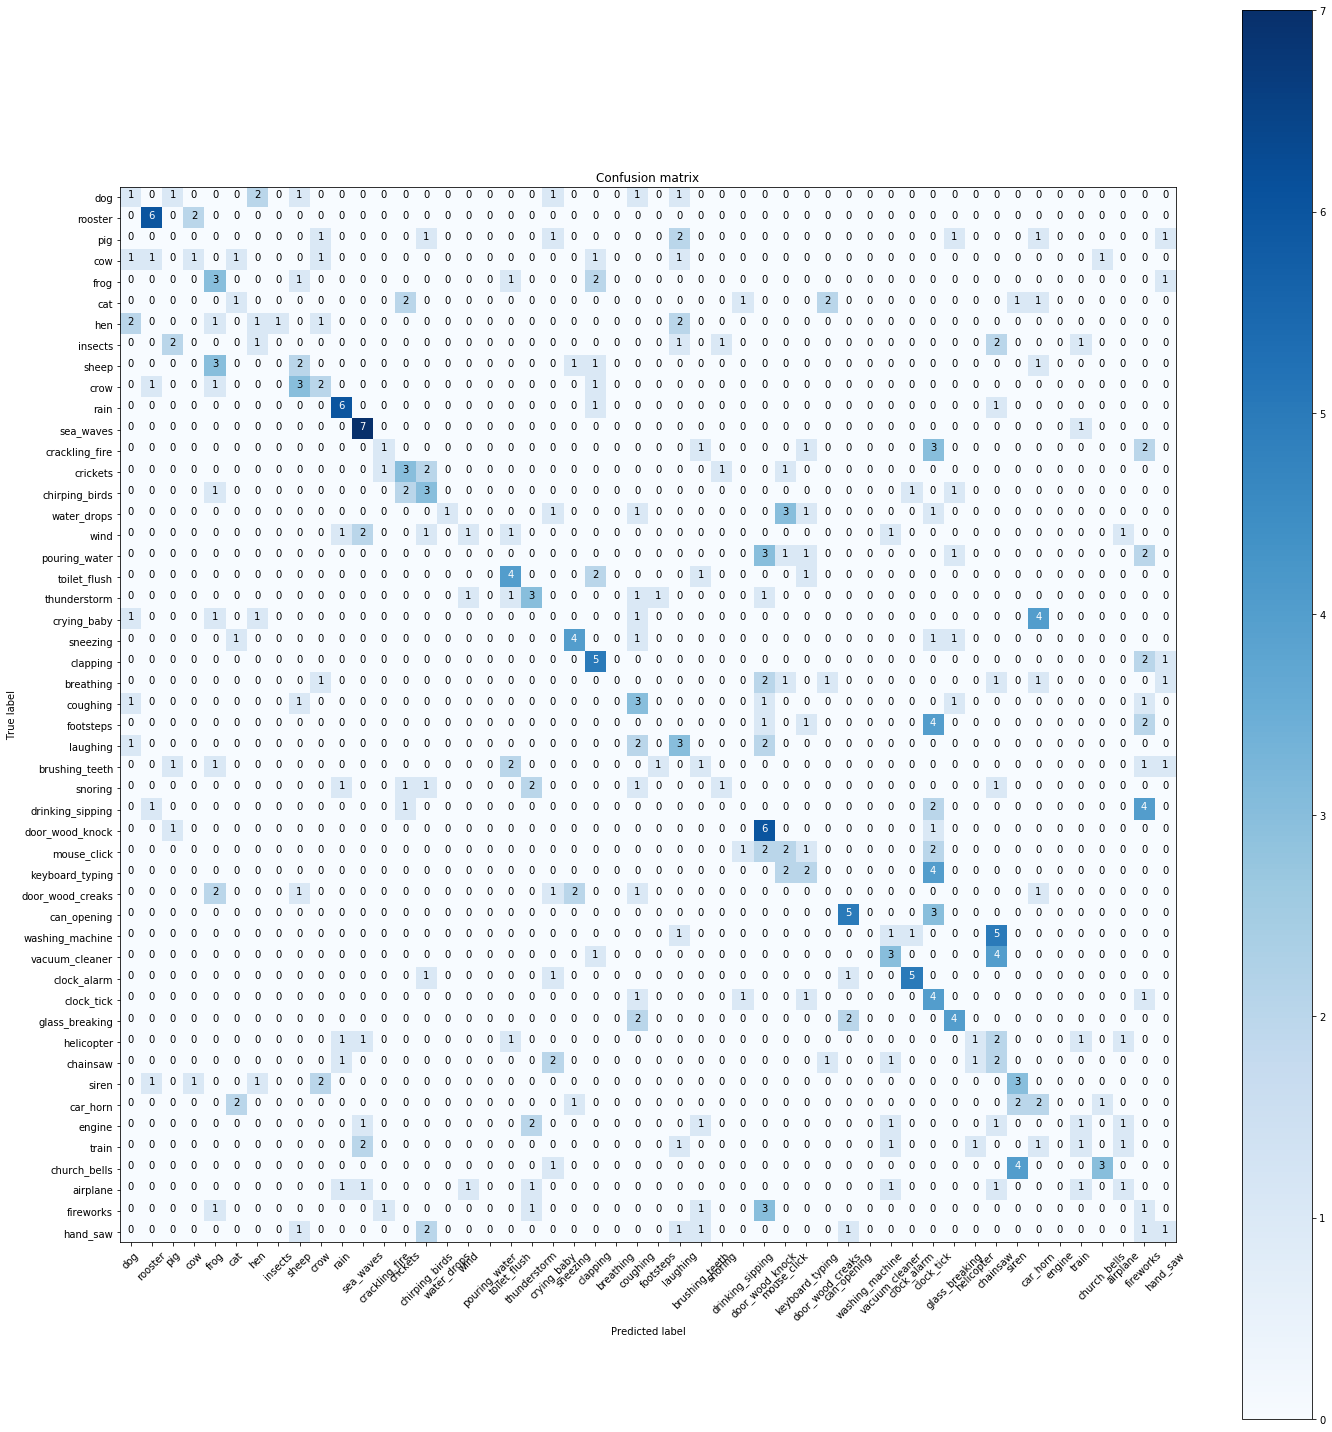

In [15]:
pred = clf.predict(test_X[:, np.newaxis, :, :])
print(metrics.accuracy_score(test_y[:,1], pred))
cm = metrics.confusion_matrix(test_y[:,1], pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [16]:
%%time
import time
from load_blockwise import load_file_blockwise

predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

test = dataset[dataset.fold == 1].reset_index()
    
for data_iloc in range(0,len(test)):
    s_time = time.time()
    x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                                 blocksize=orig_blocksize,
                                 overlap=orig_overlap)
    y_file = test.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))



	File Time: 0.2579789161682129
	File Time: 0.24916410446166992
	File Time: 0.20956730842590332
	File Time: 0.2240135669708252
	File Time: 0.22455430030822754
	File Time: 0.2615208625793457
	File Time: 0.22129321098327637
	File Time: 0.2243330478668213
	File Time: 0.20862793922424316
	File Time: 0.17846417427062988
	File Time: 0.21687579154968262
	File Time: 0.18415307998657227
	File Time: 0.18006014823913574
	File Time: 0.1971440315246582
	File Time: 0.25510334968566895
	File Time: 0.22233033180236816
	File Time: 0.26026320457458496
	File Time: 0.25084757804870605
	File Time: 0.24695777893066406
	File Time: 0.2209928035736084
	File Time: 0.26450181007385254
	File Time: 0.26618528366088867
	File Time: 0.25983262062072754
	File Time: 0.23229646682739258
	File Time: 0.2612154483795166
	File Time: 0.2497880458831787
	File Time: 0.24261760711669922
	File Time: 0.22788596153259277
	File Time: 0.2658870220184326
	File Time: 0.2503502368927002
	File Time: 0.2484290599822998
	File Time: 0.27334

	File Time: 0.2856578826904297
	File Time: 0.2629873752593994
	File Time: 0.2376081943511963
	File Time: 0.2591288089752197
	File Time: 0.20690011978149414
	File Time: 0.1771259307861328
	File Time: 0.2547018527984619
	File Time: 0.2262876033782959
	File Time: 0.28196215629577637
	File Time: 0.22545647621154785
	File Time: 0.22971749305725098
	File Time: 0.2640819549560547
	File Time: 0.26510119438171387
	File Time: 0.2792983055114746
	File Time: 0.2901580333709717
	File Time: 0.23305797576904297
	File Time: 0.2626833915710449
	File Time: 0.26073646545410156
	File Time: 0.24626374244689941
	File Time: 0.25835251808166504
	File Time: 0.2613959312438965
	File Time: 0.24424076080322266
	File Time: 0.23913073539733887
	File Time: 0.2677648067474365
	File Time: 0.22785496711730957
	File Time: 0.2652714252471924
	File Time: 0.22927236557006836
	File Time: 0.25031590461730957
	File Time: 0.23650908470153809
	File Time: 0.17891263961791992
	File Time: 0.1777937412261963
	File Time: 0.178333044

0.2725
0.25741898363074833
Confusion matrix, without normalization
[[1 0 1 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 1]]


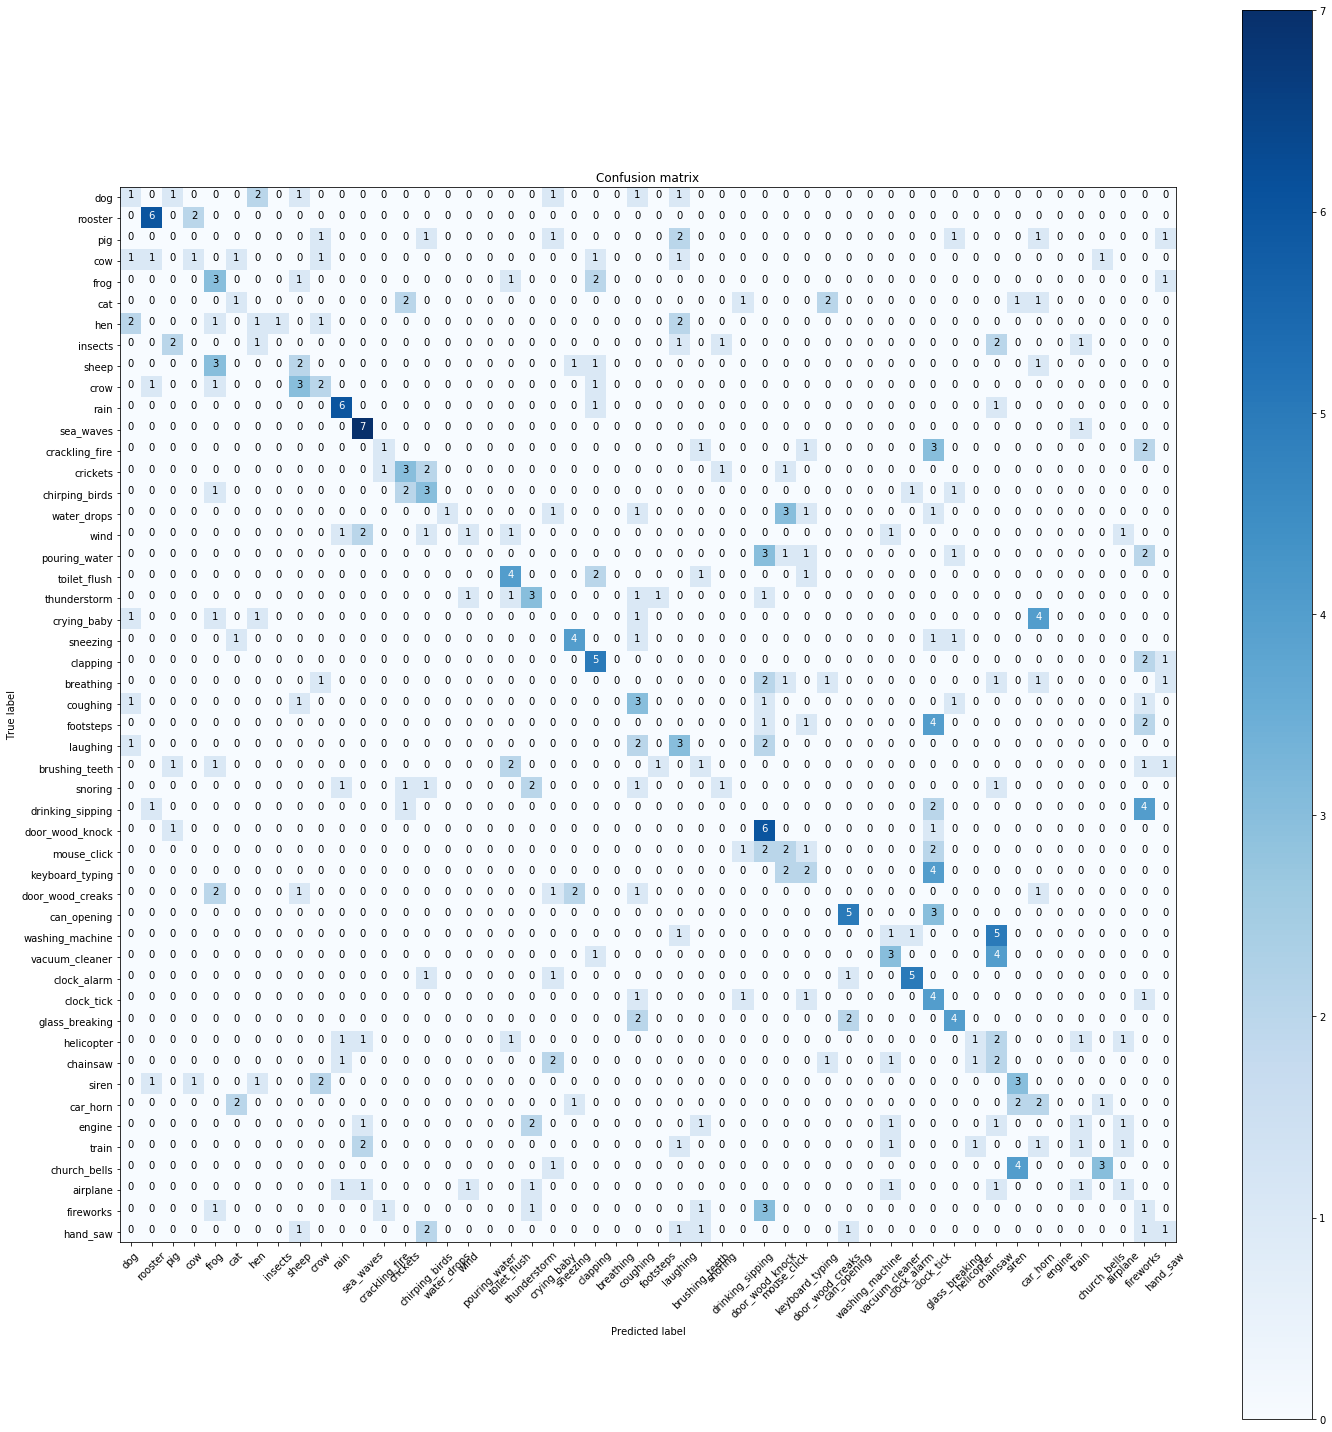

In [17]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [24]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)
    
    predictions = []

    for data_iloc in range(0,len(test)):
        x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                             blocksize=orig_blocksize,
                             overlap=orig_overlap)[0]

#         print(clf.predict_proba(x_file).shape)
        
        prob = clf.predict_proba(x_file)[l_l]
        pred = clf.predict(x_file[np.newaxis, :, :, :])
        
        predictions.append({
            'file': test.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': prob,
            'prediction': pred
        })
        
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    return predictions

In [25]:
%%time
preds = query_dataset('dog')

CPU times: user 8min 51s, sys: 1min 16s, total: 10min 8s
Wall time: 1min 53s


In [26]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
#     print(misclass)
    return (count - len(misclass))/count

In [27]:
# Checking index
check_accuracy(preds, 'dog', 10)

0.3

In [28]:
accuracies = []
for cls in classes:
    preds = query_dataset(cls)
    acc = check_accuracy(preds, cls, 10)
    print(acc)
    accuracies.append(acc)
    
np.average(accuracies)

0.3
0.6
0.2
0.1
0.3
0.1
0.2
0.1
0.1
0.4
0.7
0.7
0.2
0.2
0.4
0.2
0.2
0.3
0.5
0.3
0.2
0.5
0.5
0.0
0.2
0.1
0.2
0.1
0.2
0.1
0.5
0.3
0.4
0.0
0.5
0.4
0.4
0.5
0.3
0.4
0.2
0.2
0.2
0.2
0.0
0.3
0.5
0.2
0.0
0.2


0.27799999999999997